In [1]:
import fromscratchtoml
fromscratchtoml.use("numpy")
# fromscratchtoml.use("cupy")

from fromscratchtoml.neural_network.models import Sequential
from fromscratchtoml.neural_network.optimizers import StochasticGradientDescent
from fromscratchtoml.neural_network.layers import Dense, Activation, Dropout
from fromscratchtoml.neural_network.regularizers import l1, l2, l1_l2

import numpy as np
# import cupy as np

from sklearn.model_selection import train_test_split

from fromscratchtoml.toolbox.random import Distribution
from fromscratchtoml.toolbox.preprocess import to_onehot


In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

from fromscratchtoml.toolbox import binary_visualize

%matplotlib inline

# Neural Networks

## MNIST Digit Classification

In [8]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=".")
print(len(mnist.data))
X2 = mnist.data/256.
mnist.target.__class__
y2 = to_onehot(mnist.target)

70000


In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=10000, random_state=42)
X_train2.shape, y_train2.shape, X_train2.dtype

((60000, 784), (60000, 10), dtype('float64'))

In [10]:
model2 = Sequential(verbose=True)
# model2.add(Dropout(0.2, seed=0))

model2.add(Dense(30, input_dim=784, seed=1))
model2.add(Activation('tanh'))
# model2.add(Dropout(0.2, seed=2))

# model2.add(Dense(30))
# model2.add(Activation('relu'))
# model2.add(Dropout(0.2, seed=4))

model2.add(Dense(10, seed=2))
model2.add(Activation('softmax'))

sgd = StochasticGradientDescent(learning_rate=0.2)
model2.compile(optimizer=sgd, loss="cross_entropy")

In [11]:
%time model2.fit(X_train2, y_train2, batch_size=256, epochs=10)


epoch: 1/10  acc: 91.11  loss: 0.554 
[████                                    ] 10% 
epoch: 2/10  acc: 92.60  loss: 0.453 
[████████                                ] 20% 
epoch: 3/10  acc: 93.42  loss: 0.399 
[████████████                            ] 30% 
epoch: 4/10  acc: 94.04  loss: 0.362 
[████████████████                        ] 40% 
epoch: 5/10  acc: 94.61  loss: 0.334 
[████████████████████                    ] 50% 
epoch: 6/10  acc: 94.93  loss: 0.312 
[████████████████████████                ] 60% 
epoch: 7/10  acc: 95.26  loss: 0.293 
[████████████████████████████            ] 70% 
epoch: 8/10  acc: 95.52  loss: 0.278 
[████████████████████████████████        ] 80% 
epoch: 9/10  acc: 95.75  loss: 0.265 
[████████████████████████████████████    ] 90% 
epoch: 10/10  acc: 95.96  loss: 0.253 
[████████████████████████████████████████] 100% CPU times: user 43.1 s, sys: 31.8 s, total: 1min 14s
Wall time: 10.1 s


In [12]:
model2.accuracy(X_test2, y_test2)

95.3

## Regression

In [13]:
x_train = np.random.rand(100)
x_train = np.expand_dims(x_train, axis=1)
y_train=x_train**4

x_test=np.linspace(0,1,9)
y_test=x_test**4

In [14]:
model3 = Sequential(verbose=0)
model3.add(Dense(units=100, input_dim=1, seed=10))
model3.add(Activation('relu'))
model3.add(Dense(units=45, seed=2))
model3.add(Activation('relu'))
model3.add(Dense(units=1, seed=2))

sgd = StochasticGradientDescent(learning_rate=0.1)
model3.compile(optimizer=sgd, loss="mean_squared_error", accuracy_metric="regression")

%time model3.fit(x_train, y_train, epochs=100)

[███████████████████████████████████████ ] 99% 
epoch: 100/100  acc: -9900.00  loss: 0.000 
[████████████████████████████████████████] 100% CPU times: user 1.29 s, sys: 383 ms, total: 1.67 s
Wall time: 1.12 s


In [15]:
y_pred = model3.predict(x_train, prob=1)
y_pred[:5]

array([[0.0109173 ],
       [0.11432436],
       [0.10347559],
       [0.00821157],
       [0.00699169]])

In [16]:
y_train[:5]

array([[0.00816628],
       [0.12704146],
       [0.10765874],
       [0.00496464],
       [0.00382774]])

## Radial

In [17]:
X11 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=1,
               ed=2, seed=20)
X22 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=4,
               ed=5, seed=20)

Y11 = np.ones(X11.shape[0])
Y22 = np.zeros(X11.shape[0])

X5 = np.vstack((X11, X22))
y5 = np.hstack((Y11, Y22))

In [18]:
y5 = to_onehot(y5)

In [19]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=50, random_state=42)

In [20]:
y_train5.shape

(550, 2)

In [21]:
model5 = Sequential(verbose=1, vis_each_epoch=True)
model5.add(Dense(10, input_dim=2, seed=1))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=2))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=3))
model5.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.9)
model5.compile(optimizer=sgd, loss="mean_squared_error")

In [22]:
X_train5[0]

array([-0.81275208,  1.01547833])


epoch: 1/10  acc: 46.00  loss: 0.250 


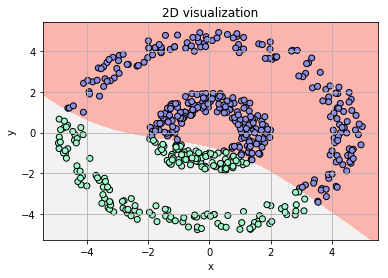

[████                                    ] 10% 
epoch: 2/10  acc: 53.64  loss: 0.249 


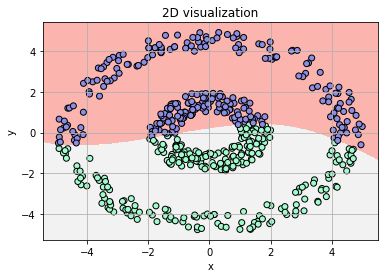

[████████                                ] 20% 
epoch: 3/10  acc: 52.73  loss: 0.248 


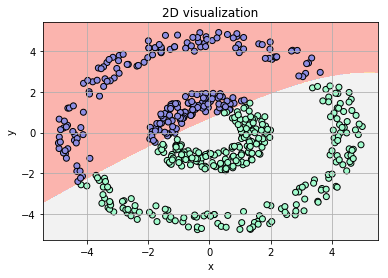

[████████████                            ] 30% 
epoch: 4/10  acc: 56.18  loss: 0.246 


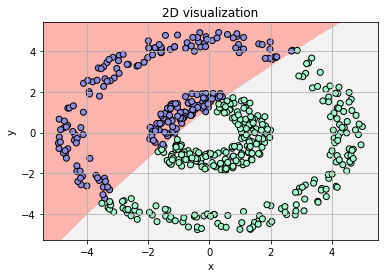

[████████████████                        ] 40% 
epoch: 5/10  acc: 58.18  loss: 0.241 


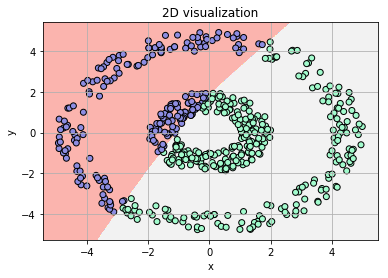

[████████████████████                    ] 50% 
epoch: 6/10  acc: 62.91  loss: 0.232 


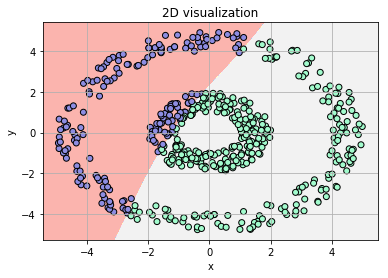

[████████████████████████                ] 60% 
epoch: 7/10  acc: 66.91  loss: 0.220 


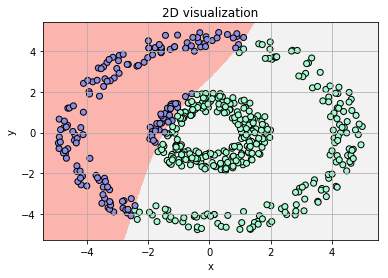

[████████████████████████████            ] 70% 
epoch: 8/10  acc: 71.27  loss: 0.206 


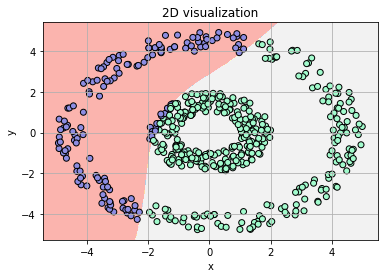

[████████████████████████████████        ] 80% 
epoch: 9/10  acc: 78.55  loss: 0.172 


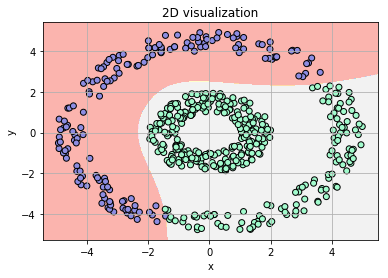

[████████████████████████████████████    ] 90% 
epoch: 10/10  acc: 98.73  loss: 0.078 


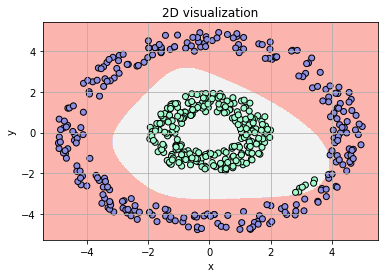

[████████████████████████████████████████] 100% CPU times: user 9.04 s, sys: 11.6 s, total: 20.6 s
Wall time: 3.59 s


In [23]:
%time model5.fit(X_train5, y_train5, batch_size=4, epochs=10)

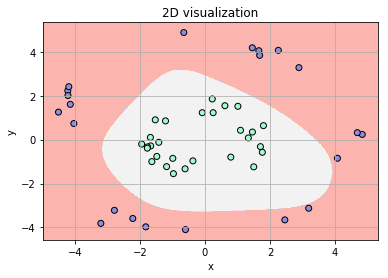

In [24]:
binary_visualize(X_test5, clf=model5, draw_contour=True)